In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import json
import logging
import os
from pprint import pprint
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim 
import torchvision.ops as ops
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import sklearn.metrics

from data_utils.vcoco_dataset import VCOCODataset
from train_loop import train_model, get_predictions

In [2]:
torch.set_num_threads(8)

In [3]:
logging.basicConfig(level=logging.INFO)

In [4]:
vc_train = VCOCODataset(
    path_to_vcoco_anns="../v-coco/data/vcoco/vcoco_train.json",
    coco_data_dir="../cocoapi",
    coco_data_type="train2017",
    override_len=1000
)

INFO:data_utils.vcoco_dataset:Loading VCOCO annotations...
INFO:data_utils.vcoco_dataset:Done!
INFO:data_utils.vcoco_dataset:Loading coco annotations...


loading annotations into memory...
Done (t=14.99s)
creating index...


INFO:data_utils.vcoco_dataset:Done!


index created!


In [5]:
vc_val = VCOCODataset(
    path_to_vcoco_anns="../v-coco/data/vcoco/vcoco_val.json",
    coco_data_dir="../cocoapi",
    coco_data_type="train2017",
    override_len=1000
)

INFO:data_utils.vcoco_dataset:Loading VCOCO annotations...
INFO:data_utils.vcoco_dataset:Done!
INFO:data_utils.vcoco_dataset:Loading coco annotations...


loading annotations into memory...
Done (t=14.86s)
creating index...


INFO:data_utils.vcoco_dataset:Done!


index created!


In [8]:
print(vc_val.vcoco.n_classes, vc_train.vcoco.n_classes)
print(vc_val.vcoco.n_annotations, vc_train.vcoco.n_annotations)
print(vc_val.vcoco.n_images, vc_train.vcoco.n_images)

26 26
4499 3932
2867 2533


In [11]:
def visualize_normalized_tensor(vc_data, idx):
    x, y = vc_data[idx]
    cat_names = [vc_data.vcoco.category_names[j] for j in np.where(y == 1)[0]]
    x_for_vis = np.moveaxis(x.data.numpy(), 0, -1)
    plt.imshow(x_for_vis)
    plt.title(f"Annotation index {idx}, categories {cat_names}")

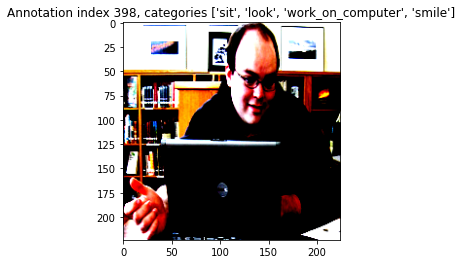

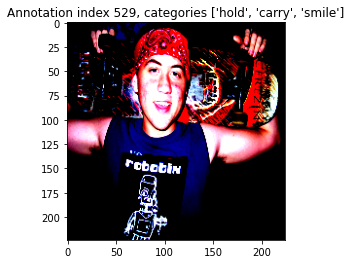

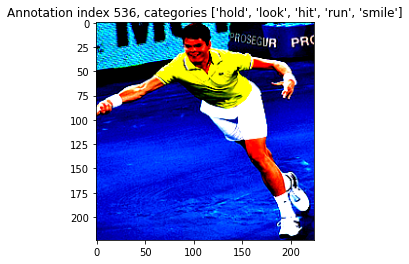

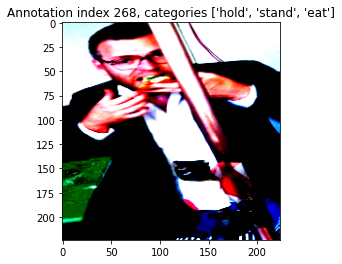

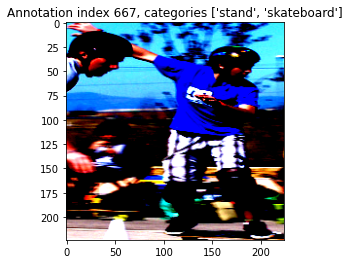

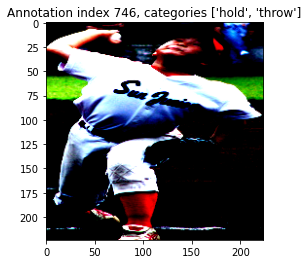

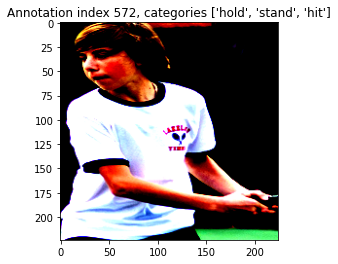

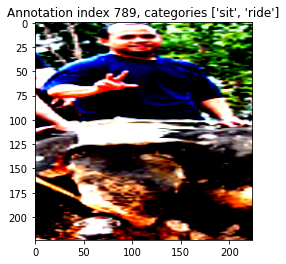

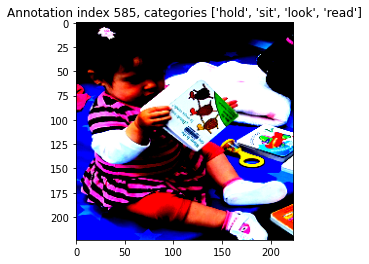

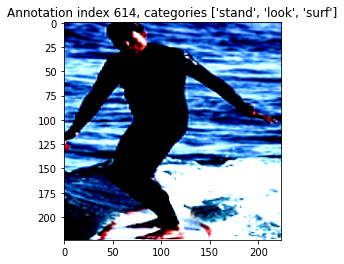

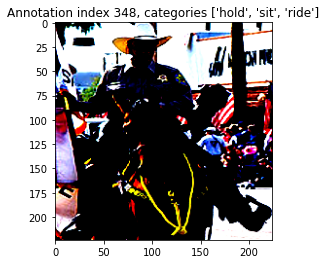

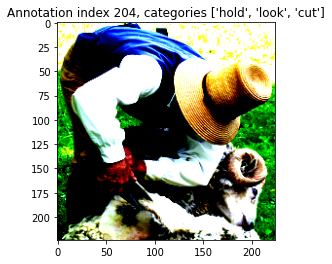

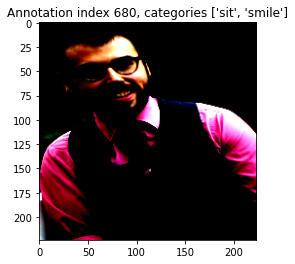

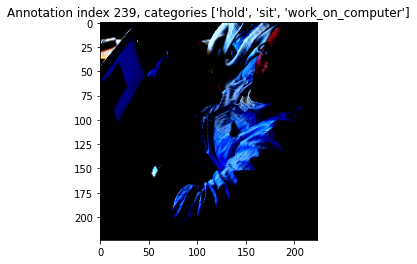

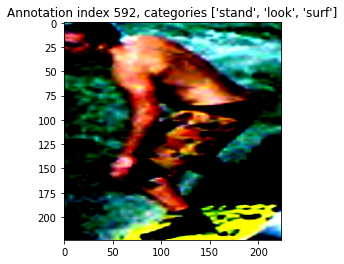

In [12]:
# Sanity check the data by looking at some random images and their labels
for idx in np.random.randint(0, len(vc_val), 15):
    plt.figure()
    visualize_normalized_tensor(vc_val, idx)

### Prepare the data

In [13]:
def create_dataloader(dataset):
    """
    Create a dataloader with our default options
    """
    return DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

In [14]:
dataloaders = {'train': create_dataloader(vc_train), 'val': create_dataloader(vc_val)}

### Prep for training: initialize model and optimizer

In [15]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
fc_in_features = model.fc.in_features
model.fc = nn.Linear(in_features=fc_in_features, out_features=vc_train.vcoco.n_classes)

In [16]:
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [17]:
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [18]:
criterion = nn.BCEWithLogitsLoss()

### Train the model

In [19]:
print(time.ctime())
train_model(model, dataloaders, criterion, optimizer, num_epochs=1)

Sat Jun  6 02:10:42 2020
Epoch 0/0
----------
train Loss: 0.3869 Acc: 0.0000
val Loss: 0.2930 Acc: 0.0000
Epoch done. Took 132.1436619758606 seconds

Training complete in 2m 12s
Best val Acc: 0.000000


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [20]:
def serialize_model_and_data(model, vc_data):
    now = datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S")
    dirname = f"model_dump_{now}"
    os.mkdir(dirname)
    with open(os.path.join(dirname, f"model_{str(model)[:10]}.pth"), "wb") as f:
        torch.save(model, f)
    with open(os.path.join(dirname, "category_names.json"), "w") as f:
        json.dump(vc_data.vcoco.category_names, f)

In [21]:
serialize_model_and_data(model, vc_train)

In [24]:
%%time
print(time.ctime())
o, l = get_predictions(model, dataloaders["val"])

Sat Jun  6 02:16:29 2020
CPU times: user 2min 38s, sys: 4.38 s, total: 2min 42s
Wall time: 1min 1s


In [25]:
l.sum() / (l.shape[0] * l.shape[1])  # fraction of positive labels

0.11219230769230769

In [26]:
a = np.asarray([])
for idx in range(vc_train.vcoco.n_classes):
    a = np.append(a, sklearn.metrics.roc_auc_score(l[:, idx], o[:, idx]))
pprint(list(zip(vc_val.vcoco.category_names, a)))
print(a.mean(), np.median(a), a)

[('hold', 0.4882375765527559),
 ('stand', 0.5077269170579031),
 ('sit', 0.5724612616083821),
 ('ride', 0.6153244218588895),
 ('walk', 0.6132437224260918),
 ('look', 0.48164530797850347),
 ('hit', 0.45227870435101036),
 ('eat', 0.6094429347826087),
 ('jump', 0.3944714109419992),
 ('lay', 0.5578804347826087),
 ('talk_on_phone', 0.49914875907990314),
 ('carry', 0.5387740869327916),
 ('throw', 0.470747211754406),
 ('catch', 0.359382404043595),
 ('cut', 0.4820511601369342),
 ('run', 0.4594299011052938),
 ('work_on_computer', 0.54662206638993),
 ('ski', 0.4263794871794872),
 ('surf', 0.5299555697236557),
 ('skateboard', 0.39261141759127255),
 ('smile', 0.5773493563812644),
 ('drink', 0.3591614378131232),
 ('kick', 0.3811743951612903),
 ('point', 0.43384576612903225),
 ('read', 0.30867260080743225),
 ('snowboard', 0.6020230639228551)]
0.4869246683266546 0.4851443683448451 [0.48823758 0.50772692 0.57246126 0.61532442 0.61324372 0.48164531
 0.4522787  0.60944293 0.39447141 0.55788043 0.49914876